In [14]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import pandas as pd
import numba
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)
from tqdm import tqdm_notebook as tqdm
import sys
sys.path.append('../src')
import plots

from rakott.mpl import legend_out, savefig_bbox

In [2]:
@numba.jit()
def recurrence(x, ρ, wA, wB):
    w = x * wA + (1 - x) * wB
    return ρ * wA/w * x + (1 - ρ) * x

@numba.jit()
def normed_binomial(N, p):    
    p[(p > 1) & ((p - 1) < 1e-15)] = 1
    p[(p > 0) & (p < 1e-15)] = 0
    return np.random.binomial(N, p) / N

@numba.jit()
def simulation_drift(N, n, ρ, wA, wB, x0, reps=1):
    x = np.empty((n, reps))
    x[0] = x0
    for t in range(1, n):
        x[t] = recurrence(x[t-1], ρ, wA[t-1], wB[t-1])
        x[t] = normed_binomial(N, x[t])
    return x

In [206]:
N = 100000
n = 1000
ρ = 0.1
p = 0.495
s = 0.1

s = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])
wA = 1 + s 
wB = np.ones(n)
print((wA - wB).mean(), np.log(1 + ρ * s).mean())
w = np.array([wA, wB]).T

-0.0002 -7.00031668733e-05


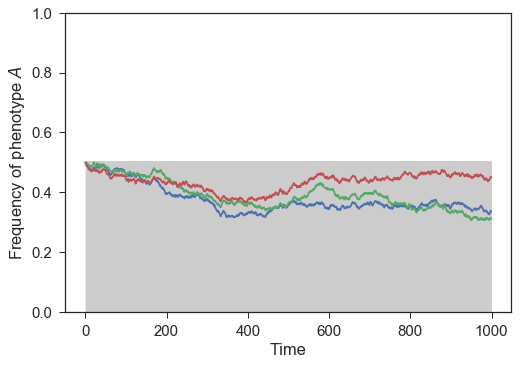

In [46]:
x = simulation_drift(N, n, ρ, wA, wB, 0.5, 3)
plt.plot(x)
plt.fill_between(range(n), 1-p, alpha=0.2, color='k')
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('Frequency of phenotype $A$')

-6.98031602063e-05 8.96765955703e-32


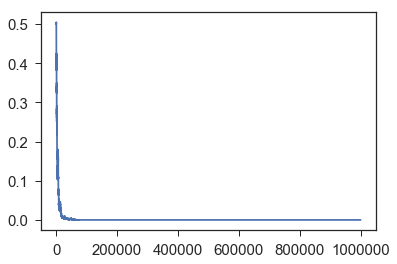

In [3]:
@numba.jit()
def simulation(x0, n, ρ, s, p):
    x = np.empty(n)
    x[0] = x0
    st = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])    
    for t in range(n-1):
        x[t + 1] = recurrence(x[t], ρ, 1.0 + st[t], 1.0)
    return x, np.log(1 + ρ * st).mean()

x, _ = simulation(0.5, 1000000, 0.1, 0.1, 0.5)
print(_, x[-1])
plt.plot(x);

In [65]:
%timeit simulation(0.5, 100000, 0.1, 0.1, 0.5)

100 loops, best of 3: 3.73 ms per loop


In [66]:
4/1000 * 100 * 100 /60

0.6666666666666666

In [4]:
n = 1000000
ρ = 0.1
x0 = 1e-4

p = np.linspace(0.48, 0.52, 100)
s = np.linspace(0.01, 0.1, 100)
x = np.empty((p.size, s.size))
Elog = np.empty((p.size, s.size))
Elog_A = np.empty((p.size, s.size))
Elog_B = np.empty((p.size, s.size))

In [5]:
for i, p_ in enumerate(tqdm(p, desc='p')):
    for j, s_ in enumerate(s):
        x_, Elog_ = simulation(x0=x0, n=n, ρ=ρ, s=s_, p=p_)
        x[i, j] = x_[-1]
        Elog[i, j] = Elog_
        Elog_A[i, j] = p_ * np.log(1 + ρ * s_) + (1 - p_) * np.log(1 - ρ * s_)
        Elog_B[i, j] = p_ * np.log(1 + ρ * (1/(1+s_) - 1)) + (1 - p_) * np.log(1 + ρ * (1/(1-s_) - 1))

KeyboardInterrupt: 

In [ ]:
with open('rand_env_sim_cache.pkl', 'wb') as f:
    pickle.dump(dict(x=x, Elog=Elog, Elog_A=Elog_A, Elog_B=Elog_B), f)

In [ ]:
with open('rand_env_sim_cache.pkl', 'rb') as f:
    d = pickle.load(f)
    x = d['x']
    Elog = d['Elog']
    Elog_A = d['Elog_A']
    Elog_B = d['Elog_B']

In [ ]:
s0 = s[(Elog_A < 0).argmin(axis=0)]
poly = np.poly1d(np.polyfit(p, s0, 1))
s0 = poly(p)

s1 = s[(Elog_B < 0).argmax(axis=0)]
poly = np.poly1d(np.polyfit(p, s1, 1))
s1 = poly(p)

In [ ]:
plt.pcolormesh(p, s, Elog_A, cmap='viridis')
plt.pcolormesh(p, s, Elog_B, cmap='viridis')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

im = ax.pcolormesh(p, s, x, cmap='viridis')
ax.plot(p, s0, ls='-', color='w')
ax.plot(p, s1, ls='-', color='w')
cb = plt.colorbar(im, ax=ax, label='Final frequency of phenotype $A$')

ax.set(
    xlabel='Probability of environment favoring $A$ - p',
    ylabel='Selection coefficient - s',
)

fig.tight_layout()
# fig.savefig('../figures/stochastic_env_x_t.pdf', bbox_inches='tight')

# Two RVs

In [6]:
# @numba.jit()
def simulation(x0, n, ρ, wA, wB):
    ρ = np.array(ρ, ndmin=1)    
    x = np.empty((n, ρ.size))
    x[0, :] = x0
    for t in range(n-1):
        w = x[t,:] * wA[t] + (1 - x[t,:]) * wB[t]
        x[t + 1,:] = ρ * x[t,:] * wA[t] / w + (1 - ρ) * x[t,:]
    return x

1.99948523664 2.00058627481


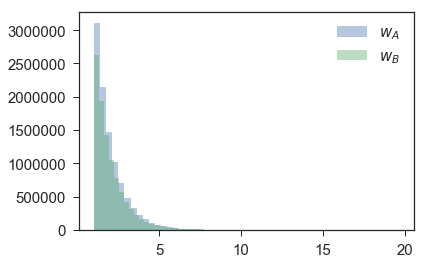

In [8]:
n = 10000000

distribution = scipy.stats.expon
rv = distribution(1)#0.1, 1)
wA = rv.rvs(n)
wB = rv.rvs(n)

sns.distplot(wA, label='$w_A$', kde=False)
sns.distplot(wB, label='$w_B$', kde=False)
plt.legend();
print(wA.mean(), wB.mean())

In [9]:
wA.mean()

1.9994852366385933

In [11]:
ρs = [0.5, 0.1, 0.01, 0.001]
x = simulation(0.00001, n, ρs, wA, wB)

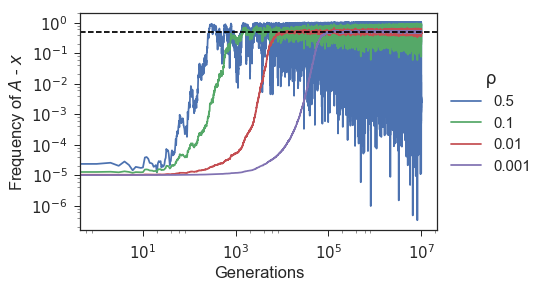

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x)
ax.axhline(0.5, color='k', ls='--')
ax.set(
    ylabel='Frequency of $A$ - $x$',
    xscale='log',
    yscale='log'
)
xlabel = ax.set_xlabel('Generations')
lg = legend_out(ax, ρs, title='ρ')
fig.savefig('../figures/stoch_two_iid_rvs.png', **savefig_bbox(xlabel, lg))